In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit
from scipy import interpolate
import pickle

from bfunc import bfunc00,bfunc01,bfunc02

Data load and region parameters

In [3]:
data = json.load(open("SFdata//595.json"))

pixscale = 0.26 # arcsec
pixscale *= 4.09                   # parsec
s0 = 4.09/2.355                    # parsec
m = 1.5

In [4]:
r = pixscale * 10**np.array(data["log10 r"])
rgrid = pixscale * np.logspace(0.0, 2)

B = np.array(data["Unweighted B(r)"])

sig2 = data["Unweighted sigma^2"]
r0 = np.interp(sig2, B, r)

44.12786785616313

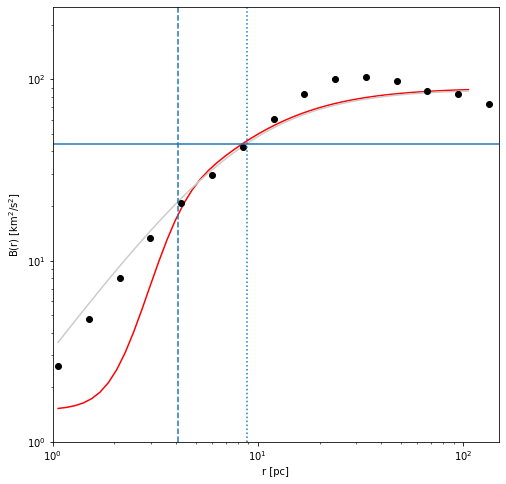

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot fit to unweighted strucfunc
ax.plot(rgrid, bfunc02(rgrid, r0, sig2, m, s0, 1.5), color="red")
ax.plot(rgrid, bfunc00(rgrid, r0, sig2, m), color="0.8")
# Plot points from unweighted strucfunc
ax.plot(r, B, 'o',  color='black')

ax.axhline(sig2)
ax.axvline(2.355 * s0, linestyle="dashed")
ax.axvline(r0, linestyle="dotted")

ax.set(
    xscale = "log",
    yscale = "log",
    ylim  = [1, 250],
    xlim  = [1, 150],
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)

sig2

In [6]:
model02 = lmfit.Model(bfunc02)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [7]:
relative_uncertainty = 0.1
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 3.0

In [8]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
#model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=1.0)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2        nan        0      inf     True    


In [9]:
result2 = model02.fit(
    B, 
    weights=weights,
    r=r, r0=r0, m=m, s0=s0, noise=1.0, sig2=sig2
)

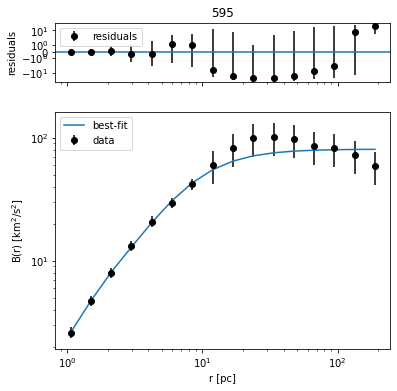

In [10]:
fig, _ = result2.plot( 'ko')
fig.axes[0].set(
    title='595',
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
);

plt.savefig('SFpaper//595.pdf', bbox_inches='tight')


In [11]:
print(result2.fit_report())

[[Model]]
    Model(bfunc02)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 16
    # variables        = 5
    chi-square         = 4.84515840
    reduced chi-square = 0.44046895
    Akaike info crit   = -9.11374055
    Bayesian info crit = -5.25079694
[[Variables]]
    r0:     8.04211112 +/- 0.80612608 (10.02%) (init = 8.818012)
    sig2:   39.5631954 +/- 3.25783707 (8.23%) (init = 44.12787)
    m:      1.83193316 +/- 0.11848224 (6.47%) (init = 1.5)
    s0:     0.60478655 +/- 0.13446752 (22.23%) (init = 1.73673)
    noise:  1.81861068 +/- 0.59581233 (32.76%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(s0, noise) =  0.909
    C(r0, sig2)  =  0.857
    C(r0, m)     = -0.780
    C(sig2, m)   = -0.535
    C(r0, s0)    =  0.292
    C(m, s0)     = -0.156
    C(r0, noise) =  0.139
    C(m, noise)  =  0.137


In [12]:
#for p in result2.model.param_names:
#    result2.params[p].stderr = result2.params[p].value * 0.1

In [13]:
result2.conf_interval()
print(result2.ci_report())

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:312: UserWarning: Bound reached with prob(s0=0.0) = 0.5826008594549714 < max(sigmas)
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:312: UserWarning: Bound reached with prob(noise=0.0) = 0.5243525872058664 < max(sigmas)
  warn(errmsg)


          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0   :  -2.48337  -1.55927  -0.76235   8.04211  +0.85594  +2.01719  +4.08146
 sig2 : -11.50128  -6.92046  -3.27256  39.56320  +3.36378  +7.34884 +12.80149
 m    :  -0.46374  -0.25324  -0.11593   1.83193  +0.12185  +0.27540  +0.50986
 s0   :      -inf      -inf      -inf   0.60479  +0.11421  +0.23541  +0.40660
 noise:      -inf      -inf      -inf   1.81861  +0.44320  +0.80294  +1.19822


In [14]:
plt.style.use([
    "seaborn-poster",
])

In [15]:
plot_limits = {
    "s0": [0.0, 2.0],
    "m": [0.8, 3],
    "r0": [5.0, 16.0],
    "noise": [0.0, 6.0],
}

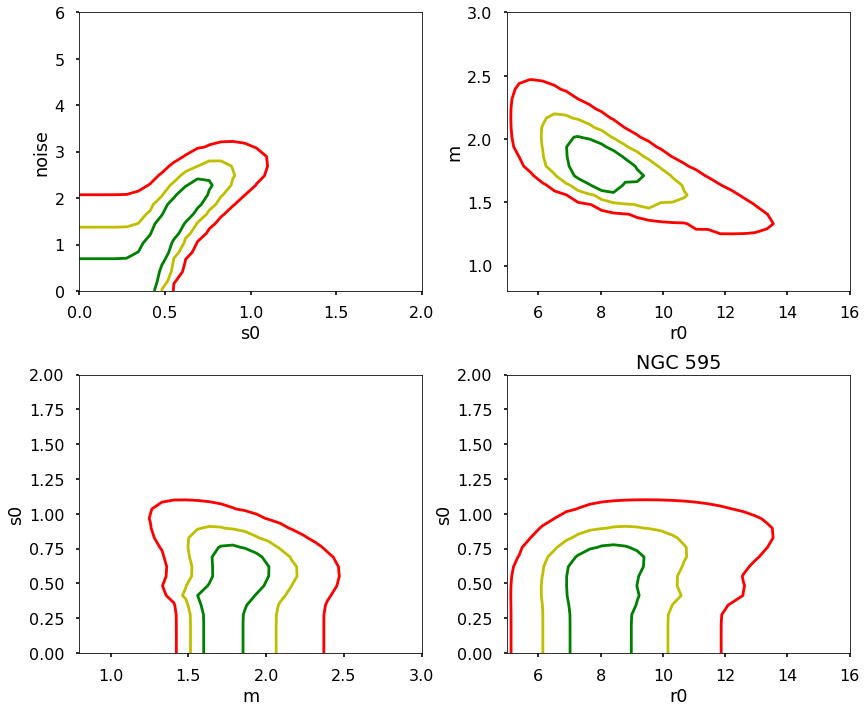

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('NGC 595')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [17]:
x=r
y=B-2*sig2
tck=interpolate.splrep(x,y,s=0)
grid=np.linspace(x.min(),x.max(),num=len(x))
ynew=interpolate.splev(grid,tck,der=0)
inter=pd.DataFrame([grid,ynew]).T
SFr=interpolate.sproot(tck)
SFr

array([18.50280992, 63.64619664])

In [18]:
r.max()/result2.params['r0'].value

23.514003919535277

In [19]:
(r[3]/2**0.5)*((result2.params['r0'].value/r[3])**(result2.params['m'].value/2))

5.233981452417512

In [20]:
#f = open('CI//595.pkl',"wb")
#pickle.dump(result2,f)
#f.close()

In [21]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 44.04550790786743 seconds ---
